In [1]:
import os

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from rdquantum.hamiltonian import Rydberg_Cz

In [2]:
# Define Hamiltonian
H = Rydberg_Cz()

In [3]:
# Create environment
env = gym.make('rdquantum/HamiltonianTrainer-v2023.04.22', Hamiltonian=Rydberg_Cz)
observation, info = env.reset()
# print(observation, info)

In [4]:
# Hyperparameters
algo = 'REINFORCE'
B = 30 # batch_size
EPOCHS = 50
eval_interval = 5
lr = 1e-2 # 1e-2 for SGD
policy_steps = 20

log_prob_clip = 5
grad_clip = 0.001
importance_ratio_eps = 0.2
value_loss_coeff = 0.5

optimizer = tf.optimizers.Adam(learning_rate=lr)
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

In [5]:
# rootdir = r'.'
r_amp = H.r_amp
r_gate_time = H.r_gate_time
# print(r_amp, r_gate_time)


# trainable variables
actions = ['omega_p_amp', 'omega_r_amp', 'delta_p_amp', 'gate_time']
mean = {s : tf.Variable(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32), name='mean_'+s) for s in actions}
sigma = {s : tf.Variable(0.5, name='sigma_'+s) for s in actions}
baseline = tf.Variable(0.0, name='baseline')

In [6]:
print(mean)
print(sigma)
print(baseline)

{'omega_p_amp': <tf.Variable 'mean_omega_p_amp:0' shape=() dtype=float32, numpy=0.9148208>, 'omega_r_amp': <tf.Variable 'mean_omega_r_amp:0' shape=() dtype=float32, numpy=0.008495569>, 'delta_p_amp': <tf.Variable 'mean_delta_p_amp:0' shape=() dtype=float32, numpy=0.78513503>, 'gate_time': <tf.Variable 'mean_gate_time:0' shape=() dtype=float32, numpy=0.2659967>}
{'omega_p_amp': <tf.Variable 'sigma_omega_p_amp:0' shape=() dtype=float32, numpy=0.5>, 'omega_r_amp': <tf.Variable 'sigma_omega_r_amp:0' shape=() dtype=float32, numpy=0.5>, 'delta_p_amp': <tf.Variable 'sigma_delta_p_amp:0' shape=() dtype=float32, numpy=0.5>, 'gate_time': <tf.Variable 'sigma_gate_time:0' shape=() dtype=float32, numpy=0.5>}
<tf.Variable 'baseline:0' shape=() dtype=float32, numpy=0.0>


In [7]:
test_action = {
    'omega_p_amp': [100/H.r_amp],
    'omega_r_amp': [175/H.r_amp],
    'delta_p_amp': [400/H.r_amp],
    'gate_time': [1.0/H.r_gate_time]
}

In [8]:
def reward_sampler(a):
    # print('a: ', a, '\n')
    rewards = []
    
    for i in range(B):
        a_np = {s : np.array(a[s][i]) for s in actions}
        # print('a_np: ', a_np, '\n')
        observation, reward, terminated, truncated, info = env.step(a_np)
        rewards.append(reward)

    return tf.cast(rewards, tf.float32)

In [9]:
def compute_log_prob(a, mean, sigma):
    sigma_eps = 1e-5 # for mumerical stability
    log_prob = 0.
    for s in actions:
        log_prob += - tf.math.log(tf.math.abs(sigma[s]) + sigma_eps) \
            - 0.5 * (a[s] - mean[s])**2 / (sigma[s]**2 + sigma_eps)
    return log_prob

In [10]:
def action_sampler(actions, sample_batch = 1):
    N = {s : tfp.distributions.TruncatedNormal(loc=mean[s], scale=sigma[s], low=0, high=1) for s in actions}
    a = {s : N[s].sample(sample_batch) for s in actions}
    return a

In [11]:
train_samples = 0
train_rewards = []
log = dict(train_rewards=[], train_epochs=[], eval_rewards=[], eval_epochs=[],
           train_actions=[], mean=[], sigma=[], baseline=[], train_samples=[],
          mean_omega_p_amp=[], mean_omega_r_amp=[], mean_delta_p_amp=[],
          mean_gate_time=[], sigma_omega_p_amp=[], sigma_omega_r_amp=[],
          sigma_delta_p_amp=[], sigma_gate_time=[])

for epoch in range(1,EPOCHS+1):

    train_samples += B

    # sample a batch of actions from Gaussian policy
    a = action_sampler(actions, sample_batch=B)

    # collect those rewards
    R =  reward_sampler(a)

    # log prob according to old policy (required for importance ratio)
    for s in actions:
        log['mean_'+s].append(mean[s].numpy())
        log['sigma_'+s].append(sigma[s].numpy())
    log['baseline'].append(baseline.numpy())
    # if epoch == 1: mean_old, sigma_old = mean, sigma
    # log_prob_old = compute_log_prob(a, mean_old, sigma_old)
    # log_prob_old = tf.clip_by_value(log_prob_old, -log_prob_clip, log_prob_clip)
    # mean_old = tf.nest.map_structure(tf.identity, mean)
    # sigma_old = tf.nest.map_structure(tf.identity, sigma)
    
    # calculate policy loss and do several gradient updates
    for i in range(policy_steps):
        with tf.GradientTape(persistent=True) as tape:
            # log prob according to the current policy
            log_prob = compute_log_prob(a, mean, sigma)
            log_prob = tf.clip_by_value(log_prob, -log_prob_clip, log_prob_clip)

            A = R - baseline # action advantages

            if algo == 'REINFORCE':
                policy_loss_batch = - A * log_prob

            # if algo == 'PPO':
            #     importance_ratio = tf.math.exp(log_prob - log_prob_old)
            #     importance_ratio_clip = tf.clip_by_value(importance_ratio, 
            #                 1-importance_ratio_eps, 1+importance_ratio_eps)
            #     policy_loss_batch = -tf.minimum(importance_ratio*A, importance_ratio_clip*A)

            policy_loss = tf.reduce_mean(policy_loss_batch) # reduce over batch
            value_loss = tf.reduce_mean(A**2)
            loss = policy_loss + value_loss_coeff * value_loss
            # print(loss)

            grads = tape.gradient(loss, tape.watched_variables())
            grads = tf.clip_by_value(grads, -grad_clip, grad_clip)
            optimizer.apply_gradients(zip(grads, tape.watched_variables()))

    log['train_rewards'].append(np.array(R))
    log['train_actions'].append(np.array(a))
    log['train_epochs'].append(epoch)
    log['train_samples'].append(train_samples)
    if epoch % eval_interval == 0:
        a_evl = action_sampler(actions, sample_batch=1)
        a_evl = {s : np.array(a_evl[s][0]) for s in actions}
        # print(a_evl)
        fidelity = H.evaluation(a_evl)
        print('Epoch %d: Fidelity = %.4f' %(epoch, fidelity))
        

run_params = dict(B = B, EPOCHS = EPOCHS, eval_interval = eval_interval,
        lr = lr, policy_steps = policy_steps, log_prob_clip = log_prob_clip,
        grad_clip = grad_clip, importance_ratio_eps = importance_ratio_eps,
        value_loss_coeff = value_loss_coeff)            

Epoch 5: Fidelity = 0.5337
Epoch 10: Fidelity = 0.9446
Epoch 15: Fidelity = 0.6443
Epoch 20: Fidelity = 0.5443
Epoch 25: Fidelity = 0.6916
Epoch 30: Fidelity = 0.6978
Epoch 35: Fidelity = 0.5641
Epoch 40: Fidelity = 0.5637
Epoch 45: Fidelity = 0.7585
Epoch 50: Fidelity = 0.5747


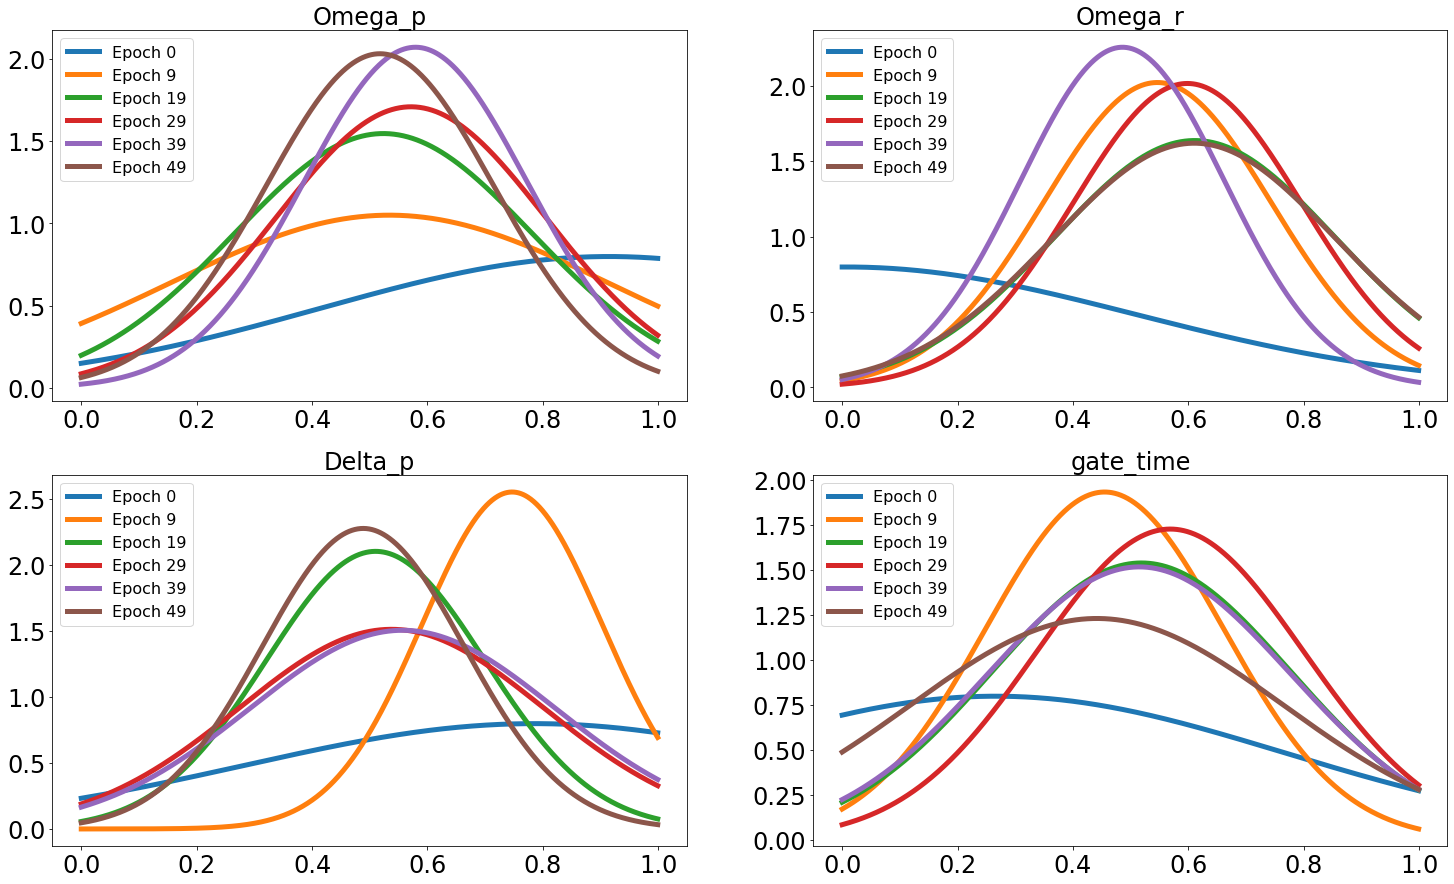

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

x_axis = np.arange(0, 1, 0.001)

plt.figure(figsize=(25, 15))

plt.subplot(221)
for i in [0, 9, 19, 29, 39, 49]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_omega_p_amp'][i],log['sigma_omega_p_amp'][i]), linewidth=5, label="Epoch %d" %i)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('Omega_p', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

plt.subplot(222)
for i in [0, 9, 19, 29, 39, 49]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_omega_r_amp'][i],log['sigma_omega_r_amp'][i]), linewidth=5, label="Epoch %d" %i)    
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('Omega_r', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

plt.subplot(223)
for i in [0, 9, 19, 29, 39, 49]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_delta_p_amp'][i],log['sigma_delta_p_amp'][i]), linewidth=5, label="Epoch %d" %i)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('Delta_p', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

plt.subplot(224)
for i in [0, 9, 19, 29, 39, 49]:
    plt.plot(x_axis, norm.pdf(x_axis,log['mean_gate_time'][i],log['sigma_gate_time'][i]), linewidth=5, label="Epoch %d" %i)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
plt.title('gate_time', fontsize=24)
plt.legend(loc="upper left", fontsize=16)

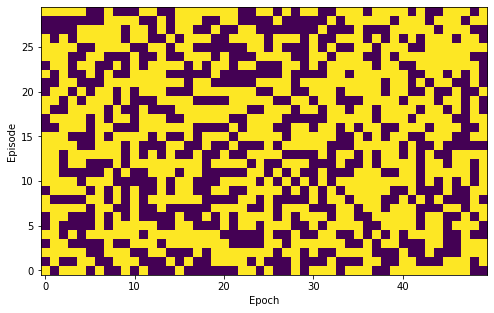

In [12]:
result = np.array(log['train_rewards'])
plt.matshow(np.reshape(result, (EPOCHS, B)).transpose())
plt.xlabel("Epoch")
plt.ylabel("Episode")
plt.gca().invert_yaxis()
plt.gca().tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
# plt.colorbar()

In [56]:
log['mean_gate_time']

[0.2659967,
 0.46575502,
 0.50217366,
 0.4687844,
 0.5265261,
 0.5684532,
 0.4879759,
 0.48848867,
 0.4533369,
 0.45479774,
 0.49565762,
 0.47065023,
 0.46064574,
 0.5069904,
 0.5546979,
 0.58844924,
 0.594591,
 0.5220266,
 0.62284607,
 0.51859164,
 0.5043954,
 0.4138641,
 0.44784087,
 0.45166638,
 0.43397403,
 0.52723527,
 0.57407814,
 0.57938945,
 0.5807638,
 0.5686029,
 0.65779036,
 0.61920667,
 0.6519697,
 0.57955813,
 0.5577227,
 0.5637239,
 0.45141432,
 0.4884185,
 0.58460194,
 0.51487195,
 0.39422846,
 0.4613533,
 0.40529662,
 0.46216848,
 0.5098403,
 0.55811524,
 0.5772334,
 0.51621133,
 0.58215797,
 0.4413652]

In [16]:
log['mean_omega_r_amp']

[0.008495569,
 0.20825389,
 0.34952357,
 0.36958268,
 0.33800817,
 0.28029647,
 0.37488705,
 0.47318336,
 0.55809534,
 0.5461046,
 0.52014124,
 0.5061386,
 0.6593647,
 0.64448494,
 0.6334365,
 0.55029225,
 0.6471691,
 0.58693594,
 0.58954823,
 0.61100274,
 0.63975567,
 0.6003308,
 0.51625615,
 0.53383017,
 0.51184976,
 0.49348858,
 0.50885135,
 0.505849,
 0.5593913,
 0.5981577,
 0.5952387,
 0.56980526,
 0.6089898,
 0.67213887,
 0.6536108,
 0.63481575,
 0.5517802,
 0.5386298,
 0.4698224,
 0.4857371,
 0.52280396,
 0.48889026,
 0.49329817,
 0.49326837,
 0.49526286,
 0.43613648,
 0.45361316,
 0.5588091,
 0.5316928,
 0.61004514]

In [17]:
log['mean_delta_p_amp']

[0.78513503,
 0.6845859,
 0.64014995,
 0.6707115,
 0.7026421,
 0.791591,
 0.73622584,
 0.67957866,
 0.7450211,
 0.74663067,
 0.7200914,
 0.6842062,
 0.6860256,
 0.6951592,
 0.6414576,
 0.6653889,
 0.643579,
 0.61948633,
 0.53330696,
 0.5100337,
 0.5441761,
 0.5686338,
 0.60019726,
 0.58489,
 0.57610536,
 0.575066,
 0.583194,
 0.59154284,
 0.65461946,
 0.5375771,
 0.5735401,
 0.5056229,
 0.442759,
 0.5146315,
 0.6086611,
 0.5383373,
 0.5939774,
 0.5722803,
 0.55260736,
 0.5569977,
 0.4386093,
 0.45573804,
 0.38252902,
 0.4122286,
 0.42339832,
 0.4994072,
 0.46067247,
 0.4614785,
 0.47488335,
 0.48869714]

In [19]:
log['baseline']

[<tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=() dtype=float32, numpy=-4.167386>,
 <tf.Variable 'baseline:0' shape=(